In [1]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
from tqdm import tqdm
import random
import tensorflow as tf
import re
import matplotlib
from matplotlib import pyplot as plt
import sys
import copy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer, Reshape
from sklearn.metrics import roc_curve, auc, average_precision_score, matthews_corrcoef, f1_score, precision_score

In [2]:
excel = 'Unambiguous sites_Version 3.0_20231119_website.xlsx'
excel_phos='20231129_Phosphoserine_Phosphothreonine.fasta.xlsx'
#file_name = 'UP000005640_9606.txt' #Reference proteome for humans
file_name = '20240212_O-GlcNAc_all_org_IDs.txt' #Uniprot seqs for Nglycosite atlas

df = pd.read_csv(file_name, sep='delimiter', header=None)

C:\Users\Clair\AppData\Local\Temp\ipykernel_8772\267186532.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_name, sep='delimiter', header=None)


In [3]:
#Load all possible Uniprot IDs from reference proteome
df.fillna("NA", inplace=True) # just in case any "NA" got turned into NaNs
ID_df = df[df[0].str.contains(">")][0]
ID_list = []
for i in range(len(ID_df)):  #This dataset uses a different Uniprot form than previous so select it differently
    long=ID_df.iloc[i].split("|")[1]
    ID_list.append(long.split(" ")[0])
ID_array = np.array(ID_list)
#print (ID_array)
print("ID array has been made!")

#Makes array of sequences
sequences = []
indices_of_uniprot_ids = list(df[df[0].str.contains(">")].index)
for i in range(len(indices_of_uniprot_ids)-1):
    # concatenate all into one string
    sequences.append(df[indices_of_uniprot_ids[i]+1:indices_of_uniprot_ids[i+1]][0].sum())
    if i == len(indices_of_uniprot_ids)-2:
        sequences.append(df[indices_of_uniprot_ids[i+1]+1:][0].sum())
sequences = np.array(sequences)
print("Lines have been separated!")

# Creates dictionary that maps Uniprot ID to sequence
pairs = zip(ID_array, sequences)
protein_dict = {A:B for A,B in pairs}
print("protein_dict has been made!")

ID array has been made!
Lines have been separated!
protein_dict has been made!


In [4]:
print (len(protein_dict))

count=0
for i in range (0, len(datasetp)):
    ID=datasetp[i, 0]
    if ID in protein_dict:
        count+=1
print (count)

5923


NameError: name 'datasetp' is not defined

In [5]:
#Load data and convert to numpy array for phos and Ogly
sheet = pd.read_excel(excel)
Data=sheet[["accession", "position_in_protein"]]

ID=Data.iloc[:, 0] 
ID=ID.to_numpy(dtype=str)

Position=Data.iloc[:, 1] 
Position=Position.to_numpy(dtype=str)

dataset=np.stack((ID, Position), axis=1)
print (np.shape(dataset))


sheetp = pd.read_excel(excel_phos)
Datap=sheetp[["UniProt ID", "Site Indexes"]]

IDp=Datap.iloc[:, 0].str.split(',', expand=True)
IDp=IDp.to_numpy(dtype=str)

Positionp=Datap.iloc[:, 1] 
Positionp=Positionp.to_numpy(dtype=object)

print (Positionp[0])
print (np.shape(IDp))
print (np.shape(Positionp))
#datasetp=np.stack((IDp, Positionp))

Positionp = [eval(ele) for ele in Positionp]

list_ID_sitep=[]
for i in range(0, len(Positionp)):
    #new_position=Positionp[i].replace("(","").replace(")","").replace(",","").replace(' ', '')
    for j in Positionp[i]:
        list_ID_sitep.append(np.array([IDp[i][0], str(j)]))
datasetp=np.stack(list_ID_sitep)

print (np.shape(datasetp))

(35673, 2)
(2, 61, 188, 235)
(28256, 1)
(28256,)
(125076, 2)


In [91]:
print (datasetp[1, :])

['P68250' '61']


In [6]:
def make_pos_kmers (dataset, protein_dict, k=53, verbose="yes"):
    """
    Makes kmers from a list of positive sites
    Site is given in bio notation (not python) which starts at 1 and is a string with the identity of the amino acid (S/T)

    This also removes sites that don't have uniprot IDs in the sequence file or have sites that point to an incorrect amino acid or are too long. 
    """
    kmers=[]
    S_site_array=[]
    T_site_array=[]
    half=int((k-1)/2)
    sites=dataset[:, 1]
    print (len(sites))
    for i in range(0, len(sites)):
        ID=dataset[i, 0]
        try:
            location=int(sites[i].replace("S","").replace("T",""))
            seq=protein_dict[ID]
            if location <= half: #To deal with sites near the n terminus
                if location > len(seq)-half: #To deal with sequences shorter than k
                    gap="-"*(half-location+1)
                    gap2="-"*int(half-(len(seq)-location))
                    kmer=seq[0 : int(location+half)]
                    kmer=gap+kmer+gap2
                else: 
                    gap="-"*(half-location+1)
                    kmer=seq[0 : int(location+half)]
                    kmer=gap+kmer
            elif location > len(seq)-half: #To deal with sites near the C terminus
                gap="-"*int(half-(len(seq)-location))
                kmer=seq[int(location-half-1): len(seq)]
                kmer=kmer+gap
            else:
                kmer=seq[int(location-half-1): int(location+half)]
            
            if location > len(seq): #Will not add to list of kmers
                if verbose == "yes":
                    print ("Site outside of seq bounds, site: "+str(location)+", sequnce length: "+str(len(seq)))
                    print (ID)
            elif seq[int(location-1)] == "S" or seq[int(location-1)]=="@":
                if kmer not in kmers:
                    S_site_array.append ((ID, location))
                    kmers.append(kmer)
            elif seq[int(location-1)] == "T" or seq[int(location-1)]=="&":
                if kmer not in kmers:
                    T_site_array.append ((ID, location))
                    kmers.append(kmer)
            else:
                if verbose == "yes":
                    print(seq[int(location-1)])
                    print ("Sequence key error for "+ID+" at " + str(location)) #Will not add it to list of kmers because doesn't match uniprot
                #raise Exception("Sequence key error for "+ID+" at " + str(location))
            if len(kmer) != k:
                if verbose == "yes":
                    print (kmer)
                    print (len(kmer))            
        except KeyError:
            if verbose == "yes":
                print(ID+" not in protein_dict")  
        except ValueError:
            if verbose == "yes":
                print (ID +"has some problem with the site loction, here is the value: "+str(sites[i]))

    print (len(kmers))
    
    return kmers, S_site_array, T_site_array

kmers, S_site_array, T_site_array=make_pos_kmers (datasetp, protein_dict)
#print (np.shape(S_site_array))
#print (np.shape(T_site_array))
#print (np.shape(kmers))
#print (S_site_array[0])

def ndtolot (ndarray):
    """
    converts 2D ndarray (n, 2) to a list of tuples
    """
    list=[]
    for i in range (0, len(ndarray[:, 0])):
        holding=(ndarray[i, 0], int(ndarray[i, 1]))
        list.append(holding)
    return list

def make_full_dataset (dataset, protein_dict, k=53, verbose="yes", opt2="no", pos_kmers0=0, S_sites0=0, T_sites0=0, humans="no"):
    """
    """
    if opt2=="yes":
        pos_kmers=pos_kmers0
        S_sites=S_sites0
        T_sites=T_sites0
    else:
        pos_kmers, S_sites, T_sites = make_pos_kmers (dataset, protein_dict, verbose=verbose)
    s=len(S_sites)
    t=len(T_sites)
        
    if humans=="yes":
        ns=ndtolot(np.load('All_human_S_sites.npy', allow_pickle=True))
        nt=ndtolot(np.load('All_human_T_sites.npy', allow_pickle=True))
    else: 
        ns=ndtolot(np.load('All_S_sites.npy', allow_pickle=True))
        nt=ndtolot(np.load('All_T_sites.npy', allow_pickle=True))
    print (type(ns[0]))

    for i in S_sites:
        try:
            ns.remove(i)
        except: 
            if verbose == "yes":
                print ("Not in negative sites: " +str(i))
    for i in T_sites:
        try:
            ns.remove(i)
        except: 
            if verbose == "yes":
                print ("Not in negative sites: " +str(i))
        
    neg_S_sites= random.sample(ns, s)
    neg_T_sites= random.sample(nt, t)
    neg_sites=neg_S_sites+ neg_T_sites
    print (len(neg_sites))
        
    #Now that we have the sites we need to make kmers
    neg_kmers=[]
    half=int((k-1)/2)
    for i in neg_sites:
        location=i[1]
        ID=i[0]
        #print (location)
        seq=protein_dict[ID]
        if location <= half:
            if location > len(seq)-half:
                gap="-"*(half-location+1)
                gap2="-"*int(half-(len(seq)-location))
                kmer=seq[0 : int(location+half)]
                kmer=gap+kmer+gap2
            else:
                gap="-"*(half-location+1)
                kmer=seq[0 : int(location+half)]
                kmer=gap+kmer
        elif location > len(seq)-half:
            gap="-"*int(half-(len(seq)-location))
            #print (len(gap))
            kmer=seq[int(location-half-1): len(seq)]
            kmer=kmer+gap
        else:
            kmer=seq[int(location-half-1): int(location+half)]
        neg_kmers.append(kmer)

    return pos_kmers, neg_kmers

#pos_kmers, neg_kmers=make_full_dataset (dataset, protein_dict, k=53)
#print (np.shape(pos_kmers))
#print (np.shape(neg_kmers))

125076
P68250 not in protein_dict
P68250 not in protein_dict
P68250 not in protein_dict
P68250 not in protein_dict
Q5ZLQ6 not in protein_dict
P31946 not in protein_dict
P31946 not in protein_dict
P31946 not in protein_dict
P31946 not in protein_dict
Q4R572 not in protein_dict
Q4R572 not in protein_dict
Q4R572 not in protein_dict
Q4R572 not in protein_dict
Q9CQV8 not in protein_dict
Q9CQV8 not in protein_dict
Q9CQV8 not in protein_dict
Q9CQV8 not in protein_dict
A4K2U9 not in protein_dict
A4K2U9 not in protein_dict
A4K2U9 not in protein_dict
A4K2U9 not in protein_dict
P35213 not in protein_dict
P35213 not in protein_dict
P35213 not in protein_dict
P35213 not in protein_dict
P68251 not in protein_dict
P68251 not in protein_dict
P68251 not in protein_dict
P68251 not in protein_dict
P62261 not in protein_dict
P62261 not in protein_dict
P62261 not in protein_dict
P62261 not in protein_dict
P92177 not in protein_dict
P62258 not in protein_dict
P62258 not in protein_dict
P62258 not in protein

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [30]:
def labeling (dataset, other_dataset, protein_dict, k=53, verbose="yes", humans="no"):
    """
    """
    kmers, S_sites, T_sites = make_pos_kmers(dataset, protein_dict, k=k, verbose=verbose)
    other_kmers, other_S_sites, other_T_sites = make_pos_kmers(other_dataset, protein_dict, k=k, verbose=verbose)
    lprotein_dict=copy.deepcopy(protein_dict)
    other_all_sites=other_S_sites+other_T_sites
    all_sites=S_sites+T_sites
    print ("Phos sites:")
    print (len(other_all_sites))
    half=int((k-1)/2)
    for i in other_S_sites:
        ID=i[0]
        location=i[1]-1 #To turn to python index
        try: #Need try except because phos sites might not be in this 
            seq=lprotein_dict[ID]
            if seq[location]=="S":
                newseq= seq[:location] + "@" + seq[location + 1:]
            elif seq[location]=="@":
                print ("Already labeled")
                newseq=seq
            else:
                print (seq[location])
                raise Exception("Index error, no S")
            lprotein_dict[ID]=newseq
        except:
            pass
    for i in other_T_sites:
        ID=i[0]
        location=i[1]-1
        try:
            seq=lprotein_dict[ID]
            if seq[location]=="T":
                newseq= seq[:location] + "&" + seq[location + 1:]
            elif seq[location]=="&":
                print ("Already labeled")
                newseq=seq
            else:
                print (ID)
                print (location)
                print (seq[location])
                print ("Index error, no T")
                #raise Exception("Index error, no T")
            lprotein_dict[ID]=newseq
        except:
            pass
    lkmers=[]
    for i in all_sites: #Can't call make_poitive_kmers b/c with labels some identical kmers are now different so need to use same set
        ID=i[0]
        location=i[1]
        seq=lprotein_dict[ID]
        if location <= half: #To deal with sites near the n terminus
            if location > len(seq)-half: #To deal with sequences shorter than k
                gap="-"*(half-location+1)
                gap2="-"*int(half-(len(seq)-location))
                kmer=seq[0 : int(location+half)]
                kmer=gap+kmer+gap2
            else: 
                gap="-"*(half-location+1)
                kmer=seq[0 : int(location+half)]
                kmer=gap+kmer
        elif location > len(seq)-half: #To deal with sites near the C terminus
            gap="-"*int(half-(len(seq)-location))
            kmer=seq[int(location-half-1): len(seq)]
            kmer=kmer+gap
        else:
            kmer=seq[int(location-half-1): int(location+half)]
        if len(kmer) != 53:
            print ("wrong kmer size")
        if kmer[half]=="@":
            rkmer=kmer[:half] + "S" + kmer[half+1:]
            lkmers.append(rkmer)
        elif kmer[half]=="&":
            rkmer=kmer[:half] + "T" + kmer[half+1:]
            lkmers.append(rkmer)
        elif kmer[half]=="S" or kmer[half]=='T': #Seems like some here didn't get labeled
            rkmer=kmer
            lkmers.append(rkmer)
        else:
            print("Incorrect value at kmer center, here is the kmer:"+kmer)
            print (ID)
            print (location)

    lpos_kmers, lneg_kmers=make_full_dataset (dataset, lprotein_dict, k=k, verbose=verbose, opt2="yes", pos_kmers0=lkmers, S_sites0=S_sites, T_sites0=T_sites, humans=humans)

    #Don't need to remove central @ and & for negatives becuase they shouldn't be there!
    return lpos_kmers, lneg_kmers


#lpos_kmers, lneg_kmers=labeling(dataset, datasetp, protein_dict, verbose="no")
#print (np.shape(lpos_kmers))
#print (np.shape(lneg_kmers))



alphabet_with_labels = "ARNDCEQGHILKMFPSTWYV@&-UX" #
alphabet_without_labels = "ARNDCEQGHILKMFPSTWYV-UX"

def convert_to_onehot(data, alphabet):
    #Creates a dict, that maps to every char of alphabet an unique int based on position
    global char_to_int
    char_to_int = dict((c,i) for i,c in enumerate(alphabet))
    encoded_data = []
    #Replaces every char in data with the mapped int
    encoded_data.extend([char_to_int[char] for char in data])
    return encoded_data

def tensor_encoding(x_data, depth, type, alphabet):
    indices = []
    t2 = []
    for i in tqdm(range(len(x_data))):
        indices.append(convert_to_onehot(x_data[i,0], alphabet))
        if len(convert_to_onehot(x_data[i,0], alphabet)) != 53:
            print (x_data[i,0])
            print ("Length off")
    array=np.stack(indices, axis=0)
    if type == 'emb':
        return array
    for i in tqdm(range(len(indices))):
        t1 = tf.one_hot(indices[i], depth) # output: [9 x 23]
        t2.append(t1)
    return t2

In [26]:
def make_datasets_train_models (dataset, other_dataset, protein_dict, folder='', k=53, trial="Trial1", verbose="no", humans="no"):
    """
    For a given dataset and protein dictionary this functions makes the positive kmers and pulls negative kmers from all known S and T sites
    k=any odd integer
    Saves files in new folder based off of "trial" input
    """
    pos_kmers, neg_kmers = make_full_dataset (dataset, protein_dict,  k=k, verbose=verbose, humans=humans)
    lpos_kmers, lneg_kmers = labeling (dataset, other_dataset, protein_dict, k=k, verbose=verbose, humans=humans)

    if 1==1: #len(pos_kmers) != len(neg_kmers) != len(lpos_kmers) != len(lneg_kmers):
        print (len(pos_kmers))
        print (len(lpos_kmers))
        print (len(neg_kmers))
        print (len(lneg_kmers))
        #raise Exception ("Check kmer construction, not all are set equal")
    y_pos=np.ones((len(pos_kmers)), dtype=np.int32)
    y_neg=np.zeros((len(neg_kmers)), dtype=np.int32)

    pos_kmers=np.array(pos_kmers)
    neg_kmers=np.array(neg_kmers)
    lpos_kmers=np.array(lpos_kmers)
    lneg_kmers=np.array(lneg_kmers)
    
    pos_k = np.stack((pos_kmers, y_pos), axis=1)
    neg_k = np.stack((neg_kmers, y_neg), axis=1)
    lpos_k = np.stack((lpos_kmers, y_pos), axis=1)
    lneg_k = np.stack((lneg_kmers, y_neg), axis=1)

    #print (np.shape(pos_k))
    #print (np.shape(lpos_k))
    #print (np.shape(neg_k))
    #print (np.shape(lneg_k))

    full= np.vstack([pos_k,neg_k])
    lfull = np.vstack([lpos_k,lneg_k])
    np.random.shuffle(full)
    np.random.shuffle(lfull)

    print (full[:, 1].dtype)
    #print (np.shape(full))
    #print (np.shape(lfull))

    x_data, y_data = np.split(full, 2, axis=1)
    x_datal, y_datal = np.split(lfull, 2, axis=1)

    #print (np.shape(x_datal))
    y_data=y_data.astype(np.int32)
    y_datal=y_datal.astype(np.int32)
    #print (y_data.dtype)
    #print (y_data)

    # Split into train, validation, and test datasets
    N = len(full)
    x_train = x_data[0:int(0.8*N), :]
    #print (x_train)
    y_train = y_data[0:int(0.8*N)]
    #print (y_train)

    x_validation = x_data[int(0.8*N):int(0.8*N)+int(0.1*N), :]
    y_validation = y_data[int(0.8*N):int(0.8*N)+int(0.1*N)]

    x_test = x_data[int(0.8*N)+int(0.1*N):, :]
    y_test = y_data[int(0.8*N)+int(0.1*N):]

    x_trainl = x_datal[0:int(0.8*N), :]
    y_trainl = y_datal[0:int(0.8*N)]

    x_validationl = x_datal[int(0.8*N):int(0.8*N)+int(0.1*N), :]
    y_validationl = y_datal[int(0.8*N):int(0.8*N)+int(0.1*N)]

    x_testl = x_datal[int(0.8*N)+int(0.1*N):, :]
    y_testl = y_datal[int(0.8*N)+int(0.1*N):]

    #Make tensors of x data
    tensor1 = tensor_encoding(x_train, 23, 'emb', alphabet_without_labels)
    tensor2 = tensor_encoding(x_validation, 23, 'emb', alphabet_without_labels)
    tensor3 = tensor_encoding(x_test, 23, 'emb', alphabet_without_labels)
    tensor4 = tensor_encoding(x_trainl, 23, 'emb', alphabet_with_labels)
    tensor5 = tensor_encoding(x_validationl, 23, 'emb', alphabet_with_labels)
    tensor6 = tensor_encoding(x_testl, 23, 'emb', alphabet_with_labels)

    print (type(tensor1))
    print (tensor1.dtype)
    print (y_train.dtype)
    #print (np.shape(tensor2))
    #print (np.shape(tensor3))
    #print (np.shape(tensor4))
    #print (np.shape(tensor5))
    #print (np.shape(tensor6))

    directory=''
    path = os.path.join(directory, trial) 
    try:
        os.mkdir(path) 
    except:
        pass
    
    #Save datasets
    np.save(f'{path}/{trial}_x_train_without_labels', tensor1)
    np.save(f'{path}/{trial}_y_train_without_labels', y_train)
    np.save(f'{path}/{trial}_x_validation_without_labels', tensor2)
    np.save(f'{path}/{trial}_y_validation_without_labels', y_validation)
    np.save(f'{path}/{trial}_x_test_without_labels', tensor3)
    np.save(f'{path}/{trial}_y_test_without_labels', y_test)
    np.save(f'{path}/{trial}_x_train_with_labels', tensor4)
    np.save(f'{path}/{trial}_y_train_with_labels', y_trainl)
    np.save(f'{path}/{trial}_x_validation_with_labels', tensor5)
    np.save(f'{path}/{trial}_y_validation_with_labels', y_validationl)
    np.save(f'{path}/{trial}_x_test_with_labels', tensor6)
    np.save(f'{path}/{trial}_y_test_with_labels', y_testl)

    #Add the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

    model = Sequential()
    model.add(Embedding(input_dim=256, output_dim=21, embeddings_initializer={'class_name': 'RandomUniform',
         'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, input_length=53, name="emb_layer"))
    model.add(Reshape((53, 21, 1), input_shape=(53, 21)))
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=(53, 21, 1), activation='relu', kernel_regularizer=l2(1e-06)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    model.compile(optimizer=Adam(1e-03), 
                  loss='BinaryCrossentropy', 
                  metrics=['accuracy'])
    history = model.fit(x=tensor1,y=y_train,
              batch_size=100, epochs=400,
              validation_data=(tensor2, y_validation), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/{directory}_emb_CNN_no_labels_{trial}.h5')
    model.evaluate(tensor3, y_test)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    pred = model.predict(tensor3).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("Without labels")
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print("AUC:", round(auc(fpr, tpr), 4))
    print("AUPRC:", round(average_precision_score(y_test, pred), 4))
    pred2 = (pred > 0.5)
    pred2 = np.array(pred2)
    pred2 = pred2.astype(int)
    print("MCC:", round(matthews_corrcoef(y_test, pred2), 4))
    print("F1:", round(f1_score(y_test, pred2), 4))
    print("Sensitivity:", round(np.average(tpr), 4))
    print("Specificity:", round(np.average(1-fpr), 4))
    print("Precision:", round(precision_score(y_test, pred2), 4))

    #Now with labels
    historyl = model.fit(x=tensor4,y=y_trainl,
              batch_size=100, epochs=400,
              validation_data=(tensor5, y_validationl), 
              callbacks=[callback], verbose=1)
    model.save(f'{path}/{directory}_emb_CNN_with_labels_{trial}.h5')
    model.evaluate(tensor6, y_testl)

     # The predictions are between 0 and 1 because of the sigmoid activation
    # function of the last layer in the NN
    predl = model.predict(tensor6).flatten()

    # We can also calculate the AUC to get an estimate how good the NN actually learned
    print ("With labels")
    fprl, tprl, thresholdsl = roc_curve(y_testl, predl)
    print("AUC:", round(auc(fprl, tprl), 4))
    print("AUPRC:", round(average_precision_score(y_testl, predl), 4))
    pred2l = (predl > 0.5)
    pred2l = np.array(pred2l)
    pred2l = pred2l.astype(int)
    print("MCC:", round(matthews_corrcoef(y_testl, pred2l), 4))
    print("F1:", round(f1_score(y_testl, pred2l), 4))
    print("Sensitivity:", round(np.average(tprl), 4))
    print("Specificity:", round(np.average(1-fprl), 4))
    print("Precision:", round(precision_score(y_testl, pred2l), 4))

In [31]:
for trial_num in range(1, 11):
    make_datasets_train_models (dataset, datasetp, protein_dict, k=53, trial="Trial"+str(trial_num), verbose="no", humans="no")

35673
15208
<class 'tuple'>
15208
35673
15208
125076
7474
Phos sites:
7474
<class 'tuple'>
15208
15208
15208
15208
15208
<U53


100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 45504.11it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape (Reshape)           (None, 53, 21, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 9, 16)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 32)                115232    
                    

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 38815.48it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_1 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3600)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 40368.62it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_2 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3600)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 36286.29it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_3 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3600)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 35453.72it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_4 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3600)              0         
                                                                 
 dense_8 (Dense)             (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 18639.45it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_5 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 3600)              0         
                                                                 
 dense_10 (Dense)            (None, 32)                115232    
                  

100%|████████████████████████████████████████████████████████████████████████████| 3043/3043 [00:01<00:00, 2781.54it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_6 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 3600)              0         
                                                                 
 dense_12 (Dense)            (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 26189.17it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_7 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 3600)              0         
                                                                 
 dense_14 (Dense)            (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 38802.03it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_8 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 3600)              0         
                                                                 
 dense_16 (Dense)            (None, 32)                115232    
                  

100%|███████████████████████████████████████████████████████████████████████████| 3043/3043 [00:00<00:00, 37251.85it/s]


<class 'numpy.ndarray'>
int32
int32
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 emb_layer (Embedding)       (None, 53, 21)            5376      
                                                                 
 reshape_9 (Reshape)         (None, 53, 21, 1)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 51, 19, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 25, 9, 16)        0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 3600)              0         
                                                                 
 dense_18 (Dense)            (None, 32)                115232    
                  

{2: 168, 4: 126, 19: 110, 3: 188, 18: 122, 11: 108, 20: 90, 16: 102, 15: 144, 9: 118, 6: 158, 17: 128, 13: 116, 14: 110, 5: 148, 22: 100, 1: 122, 12: 114, 8: 118, 25: 100, 26: 114, 23: 104, 10: 130, 21: 120, 24: 102, 7: 138}
[[  2 168]
 [  4 126]
 [ 19 110]
 [  3 188]
 [ 18 122]
 [ 11 108]
 [ 20  90]
 [ 16 102]
 [ 15 144]
 [  9 118]
 [  6 158]
 [ 17 128]
 [ 13 116]
 [ 14 110]
 [  5 148]
 [ 22 100]
 [  1 122]
 [ 12 114]
 [  8 118]
 [ 25 100]
 [ 26 114]
 [ 23 104]
 [ 10 130]
 [ 21 120]
 [ 24 102]
 [  7 138]]


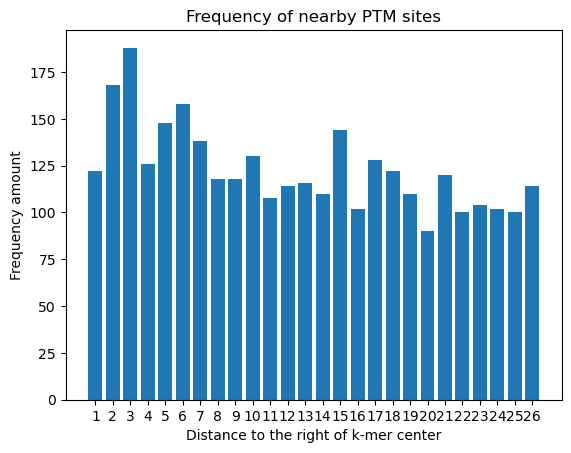

array([[  1, 122],
       [  2, 168],
       [  3, 188],
       [  4, 126],
       [  5, 148],
       [  6, 158],
       [  7, 138],
       [  8, 118],
       [  9, 118],
       [ 10, 130],
       [ 11, 108],
       [ 12, 114],
       [ 13, 116],
       [ 14, 110],
       [ 15, 144],
       [ 16, 102],
       [ 17, 128],
       [ 18, 122],
       [ 19, 110],
       [ 20,  90],
       [ 21, 120],
       [ 22, 100],
       [ 23, 104],
       [ 24, 102],
       [ 25, 100],
       [ 26, 114]])

In [25]:
def frequency(k, kmers, model):
    """

    Parameters
    ----------
    k : int
        an odd number that specifies that length of the kmer with the
        phosphorylation site in the middle
    kmer : 2D array
        1D array with kmers

    Returns
    -------
    frequencies : 2D array
        2D array with columns distance away from center kmer PTM and 
        frequency of nearby PTMS

    """
    around_ind = k//2
    x=0
    z=0
    frequencies = {}
    for i in range(0, len(kmers)):
        if "@" in kmers[i]:
            x+=1
        elif "&" in kmers[i]:
            z+=1
        temp = kmers[i][around_ind+1:]
        for j in range(len(temp)):
            if "@" == temp[j]:
                if j+1 in frequencies.keys():
                    frequencies[j+1] += 1
                else:
                    frequencies[j+1] = 1
            elif "&" ==temp[j]:
                if j+1 in frequencies.keys():
                    frequencies[j+1] += 1
                else:
                    frequencies[j+1] = 1        
        
    print (frequencies)
    frequencies = list(frequencies.items())
    frequencies = np.array(frequencies)
    print (frequencies)
    frequencies = frequencies[frequencies[:,0].argsort()]

    plt.figure(0)
    plt.bar(frequencies[:,0], frequencies[:,1])
    plt.xticks(frequencies[:,0])
    plt.title("Frequency of nearby PTM sites")
    plt.ylabel("Frequency amount")
    plt.xlabel("Distance to the right of k-mer center")
    plt.savefig(model+"_frequencies.pdf", transparent=True)
    plt.show()

    return frequencies

#pos_kmers, neg_kmers = labeling (dataset, datasetp, protein_dict, humans="no", verbose="no")

frequency (53, lpos_kmers, model="O-GlcNAc_phos_labels_All_org")

In [14]:
test='IILTDQGMDLTSLAVEARKYGLALDPVSGRQSTAVQPLVINLNAQEQTHTFLA'
print (test[2])

L
